# Восстановление золота из руды

**План проекта:**
        
1. Описание задачи 
2. Подготовка данных
3. Анализ данных
4. Обучение моделей
5. Итоговые выводы
6. Отчет

## 1. Описание задачи

Нам нужно подготовить прототип модели машинного обучения для компании «Цифра». Она разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении имеются данные с параметрами добычи и очистки. Модель должна помочь оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


**Условия задачи:**  
  
Данные индексируются датой и временем получения информации (date). Соседние по времени параметры часто похожи.  
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке (data_test) отсутствуют некоторые признаки, которые могут быть в обучающей (data_train). Также в тестовом наборе нет целевых признаков.  
Исходный датасет (data_full) содержит обучающую и тестовую выборки со всеми признаками.  
  
**Шаги выполнения:**
  
- подготовить данные;
- провести исследовательский анализ данных;
- построить и обучить модель.


## 2. Подготовка данных

### Изучение общей информации о данных

In [1]:
# импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler 

from numpy.random import RandomState

from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# прочитаем датасеты

try:
    data_train = pd.read_csv(
        '/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv(
        '/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv(
        'datasets/gold_recovery_full_new.csv')
except:
    data_train = pd.read_csv(
        'https://code.s3.yandex.net//datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv(
        'https://code.s3.yandex.net//datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv(
        'https://code.s3.yandex.net//datasets/gold_recovery_full_new.csv')

**У нас три датасета:**

- `data_train` — обучающая выборка;
- `data_test` — тестовая выборка;
- `data_full` — исходные данные.  
  
Посмотрим на данные и их описание.

In [3]:
# проверим датасет train

data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
# проверим датасет test

data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
# проверим датасет full

data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


**Описание данных:**   
  
**_Технологический процесс:_**
  
- `Rougher feed` — исходное сырье
- `Rougher additions (или reagent additions)` — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **  — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота  
  
**_Параметры этапов:_** 
  
- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи  
  
**_Наименование признаков:_** 
  
Должно быть такое: `[этап].[тип_параметра].[название_параметра]`  
Пример: `rougher.input.feed_ag`
  
Возможные значения для блока `[этап]`:  
  
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики
  
Возможные значения для блока `[тип_параметра]`:  
  
- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики

In [6]:
# проверим размеры датасетов

for data in data_train, data_test, data_full:
    print(data.shape)

(14149, 87)
(5290, 53)
(19439, 87)


In [7]:
# проверим на явные дубликаты

for data in data_train, data_test, data_full:
    print(data.duplicated().sum())

0
0
0


In [8]:
# проверим количество строк и типы данных выборки train

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [9]:
# проверим количество строк и типы данных выборки test

data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [10]:
# проверим количество строк и типы данных выборки full

data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [11]:
# посмотрим сколько у нас столбцов без и с пропущенными значениями
# напишем функцию для подсчета количества

def na_values(data):
    
    full_columns=[]
    na_columns=[]
    
    for column in data:
        if data[column].isna().sum()==0:
            full_columns.append(column)
        if data[column].isna().sum()!=0:
            na_columns.append(column)
    return(len(full_columns), len(na_columns), round(len(na_columns)/ len(data.columns)* 100))        


In [12]:
# применим функцию к данным наших выборок

for data in data_train, data_test, data_full:
    print(na_values(data))

(25, 62, 71)
(41, 12, 23)
(24, 63, 72)


Итак, мы имеем три датасета с данными без явных дубликатов:  
  
- `data_train` - размером 87 столбцов и 14149 строк, в которых 62 имеют пропущенные значения, а 25 не имеют
- `data_test`- размером 53 столбцов и 5290 строк, в которых 12 имеют пропущенные значения, а 41 не имеют
- `data_full`- размером 87 столбцов и 19439 строк, в которых 63 имеют пропущенные значения, а 24 не имеют
  
Преступим к проверке эффективности, анализу признаков и подготовке данных.

### Вычисление эффективности обогащения

Вычислите её на обучающей выборке для признака `rougher.output.recovery`. Найдите MAE между нашими расчётами и значением признака.

In [13]:
# вычислим эффективность обогащения для признака rougher.output.recovery

C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

data_train['rougher.output.recovery_calculation'] = (C*(F-T)) / (F*(C-T))*100

data_train['rougher.output.recovery_calculation']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery_calculation, Length: 14149, dtype: float64

In [14]:
# рассчитаем среднюю абсолютную ошибку (MAE) между расчетами и значением признака rougher.output.recovery

mean_absolute_error(data_train['rougher.output.recovery'], data_train['rougher.output.recovery_calculation'])

9.73512347450521e-15

Значение MAE низкое, почти 0, поэтому можно сделать вывод, что вычисление эффективности обогащения в данных датасета верные.

### Анализ признаков, недоступных в тестовой выборке


In [15]:
# выведем только те столбцы, которых нет в тестовой выборке
# перед выводом удалим нами добавленный расчет параметра recovery

not_in_test = data_train.drop(columns=list(data_test.columns))
del not_in_test['rougher.output.recovery_calculation']
not_in_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                                14149 non-null  float64


**Мы видим, что в тестовой выборке отсутствуют:**   
  
- столбцы с другими металламми `ag`, `pb`, `sol`
- признак `recovery`
- целевый признаки для модели `rougher.output.recovery` и `final.output.recovery`
- значения `output` по всем операциям с золотом  
  
Данные output - это все данные, которые получаются по факту реальных измерений, значит они и не должны быть в тестовой выборке. Так же нам не нужны в ней расчеты по другим металлам. Нас интерисуют только золото.   
  
Но значения целевых признаков нам будут необзодимы для рассчетов ML-моделей, поэтому следует добавить столбцы со значениями `rougher.output.recovery` и `final.output.recovery`.

### Предобработка данных


In [16]:
# первым шагом добавим столбцы с данными rougher.output.recovery и final.output.recovery в тестовую выборку

data_test = data_test.merge(data_full[['rougher.output.recovery', 'final.output.recovery', 'date']], 
                            how='left', on='date')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [17]:
# пересчитаем количество пропусков в тестовой выборке после добавления новых столбцов функцией na_values

na_values(data_test)

(43, 12, 22)

Итак, объединив известные нам данные с шага знакомста с датасетами и новые данные про тетсовую выборку, мы имеем три датасета с данными без явных дубликатов и следующей информацией по пропущенным значениям:  
  
- `data_train` - размером 55 столбцов и 14149 строк, в которых 44 имеют пропущенные значения, а 11 не имеют
- `data_test` - размером 55 столбцов и 5290 строк, в которых 12 имеют пропущенные значения, а 43 не имеют
- `data_full`- размером 87 столбцов и 19439 строк, в которых 63 имеют пропущенные значения, а 24 не имеют  
  
Нам нужно заполнить пропуски для дальнейшей работы. Их условия известно, что данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи. Мы можем воспользоваться этой информацией и заполнить пропуски похожими значениями исходя из соседних временных парпаметров.

In [18]:
# заполним пропуски соседними по времени параметрами

for data in (data_train, data_test, data_full):
    data.fillna(method='ffill', inplace=True)

In [19]:
# проверим остались ли пропуски функцией na_values

na_values(data_test), na_values(data_train), na_values(data_full)

((55, 0, 0), (88, 0, 0), (87, 0, 0))

### Вывод


На данном этапе мы изучили и подготовили данные для дальнейшей работы:
  
- проверили дубликаты, пропуски
- посчитали значение MAE и выснили, что его значение почти 0, поэтому можно сделать вывод, что вычисление эффективности обогащения в данных датасета верные
- проверили, каких данных не хватает в тестовой выборке и добавили два столбца `rougher.output.recovery` и `final.output.recovery` для дальнейшей работы с моделями машинного обучения
- заполнили пропуски в данных  
      
В итоге у нас есть три подготовленных датасета с данными без явных дубликатов и без пропусков:  
  
- `data_train` - размером 88 столбцов и 14149 строк
- `data_test` - размером 55 столбцов и 5290 строк
- `data_full`- размером 87 столбцов и 19439 строк

## Анализ данных

### Изменения концентрация металлов (Au, Ag, Pb) на различных этапах очистки

У нас есть следующие этапы очистки в данных:  
  
- `input` — входное сырье
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики  
  
При этом в данных мы имеем как сам концентрат, так и хвосты. Для анализа возьмем обучающую выборку и отбросим строки с хвостами.  
Посколько secondary_cleaner содержит output только для хвостов, то этот этап мы для анализа не берем. Помимо этого мы не берем информацию о sol (соль). Смотрим только металлы.   
  
Тогда нам нужны только столбцы:  
  
- `final.input.feed_ag`
- `final.input.feed_pb`
- `final.input.feed_au`
- `final.output.concentrate_ag`
- `final.output.concentrate_pb`
- `final.output.concentrate_au`
- `primary_cleaner.output.concentrate_ag`
- `primary_cleaner.output.concentrate_pb`
- `primary_cleaner.output.concentrate_au`
- `rougher.output.concentrate_ag`
- `rougher.output.concentrate_pb`
- `rougher.output.concentrate_au`


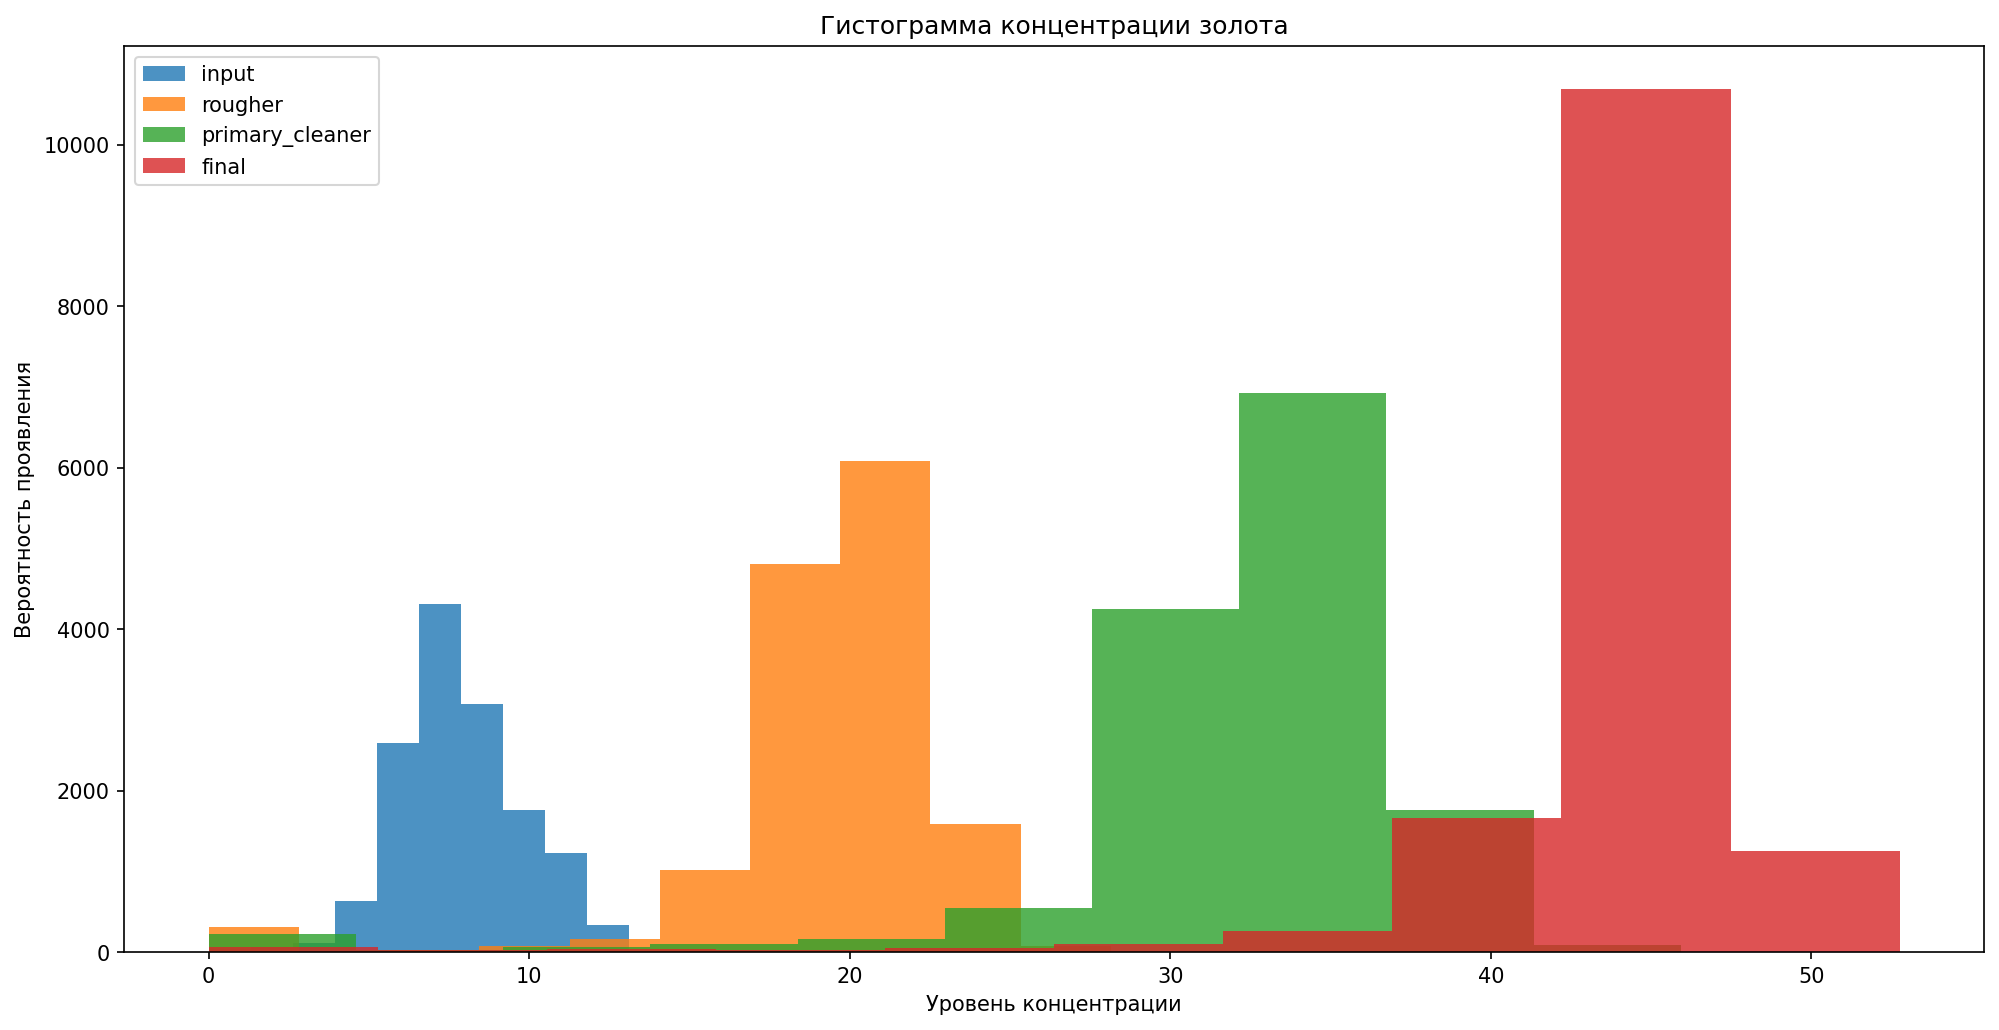

In [20]:
# строим гистограмму концентрации золота на разных этапах очистки

plt.figure(figsize=(16, 8), dpi=150); 

data_train['rougher.input.feed_au'].plot(kind='hist',label='input', alpha=.8)
data_train['rougher.output.concentrate_au'].plot(kind='hist',label='rougher', alpha=.8)
data_train['primary_cleaner.output.concentrate_au'].plot(kind='hist',label='primary_cleaner', alpha=.8)
data_train['final.output.concentrate_au'].plot(kind='hist',label='final', alpha=.8)

plt.title('Гистограмма концентрации золота')
plt.xlabel('Уровень концентрации')
plt.ylabel('Вероятность проявления')
plt.legend()
plt.show();

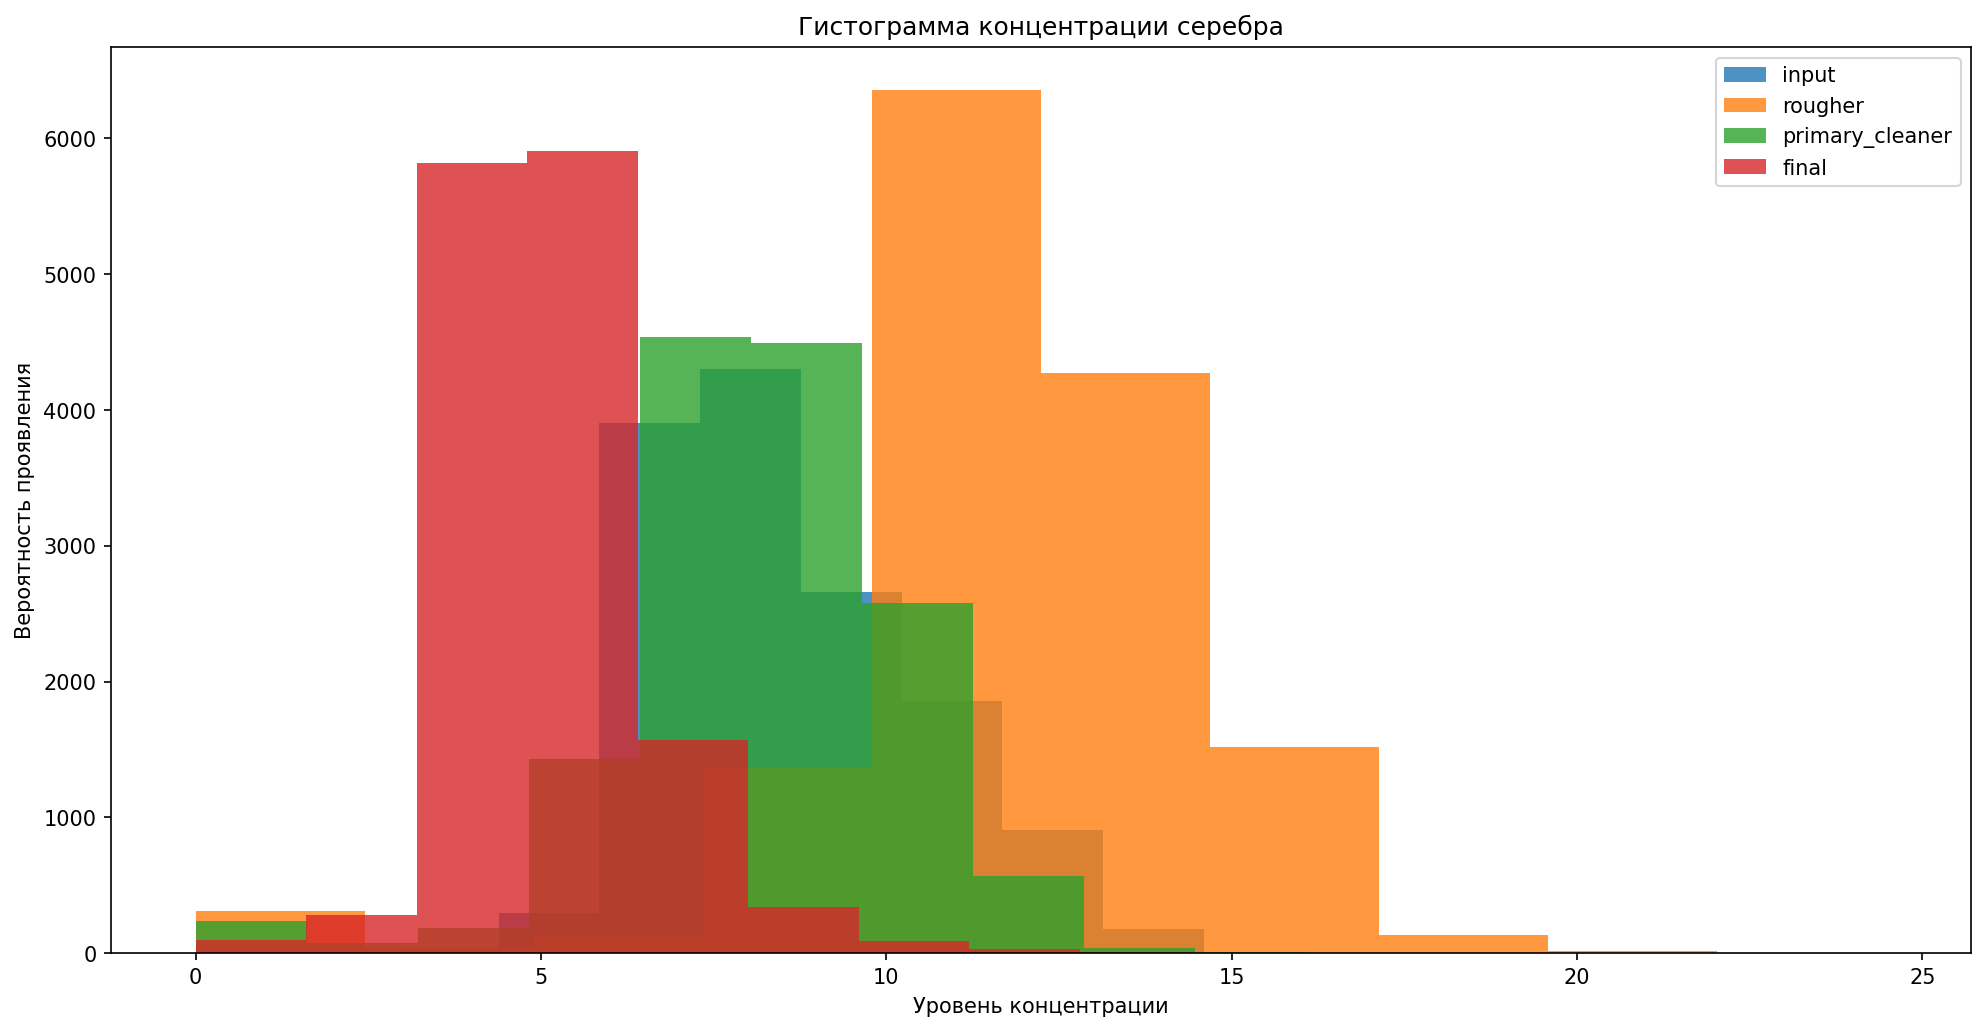

In [21]:
# строим гистограмму концентрации серебра на разных этапах очистки

plt.figure(figsize=(16, 8), dpi=150); 

data_train['rougher.input.feed_ag'].plot(kind='hist',label='input', alpha=.8)
data_train['rougher.output.concentrate_ag'].plot(kind='hist',label='rougher', alpha=.8)
data_train['primary_cleaner.output.concentrate_ag'].plot(kind='hist',label='primary_cleaner', alpha=.8)
data_train['final.output.concentrate_ag'].plot(kind='hist',label='final', alpha=.8)

plt.title('Гистограмма концентрации серебра')
plt.xlabel('Уровень концентрации')
plt.ylabel('Вероятность проявления')
plt.legend()
plt.show();

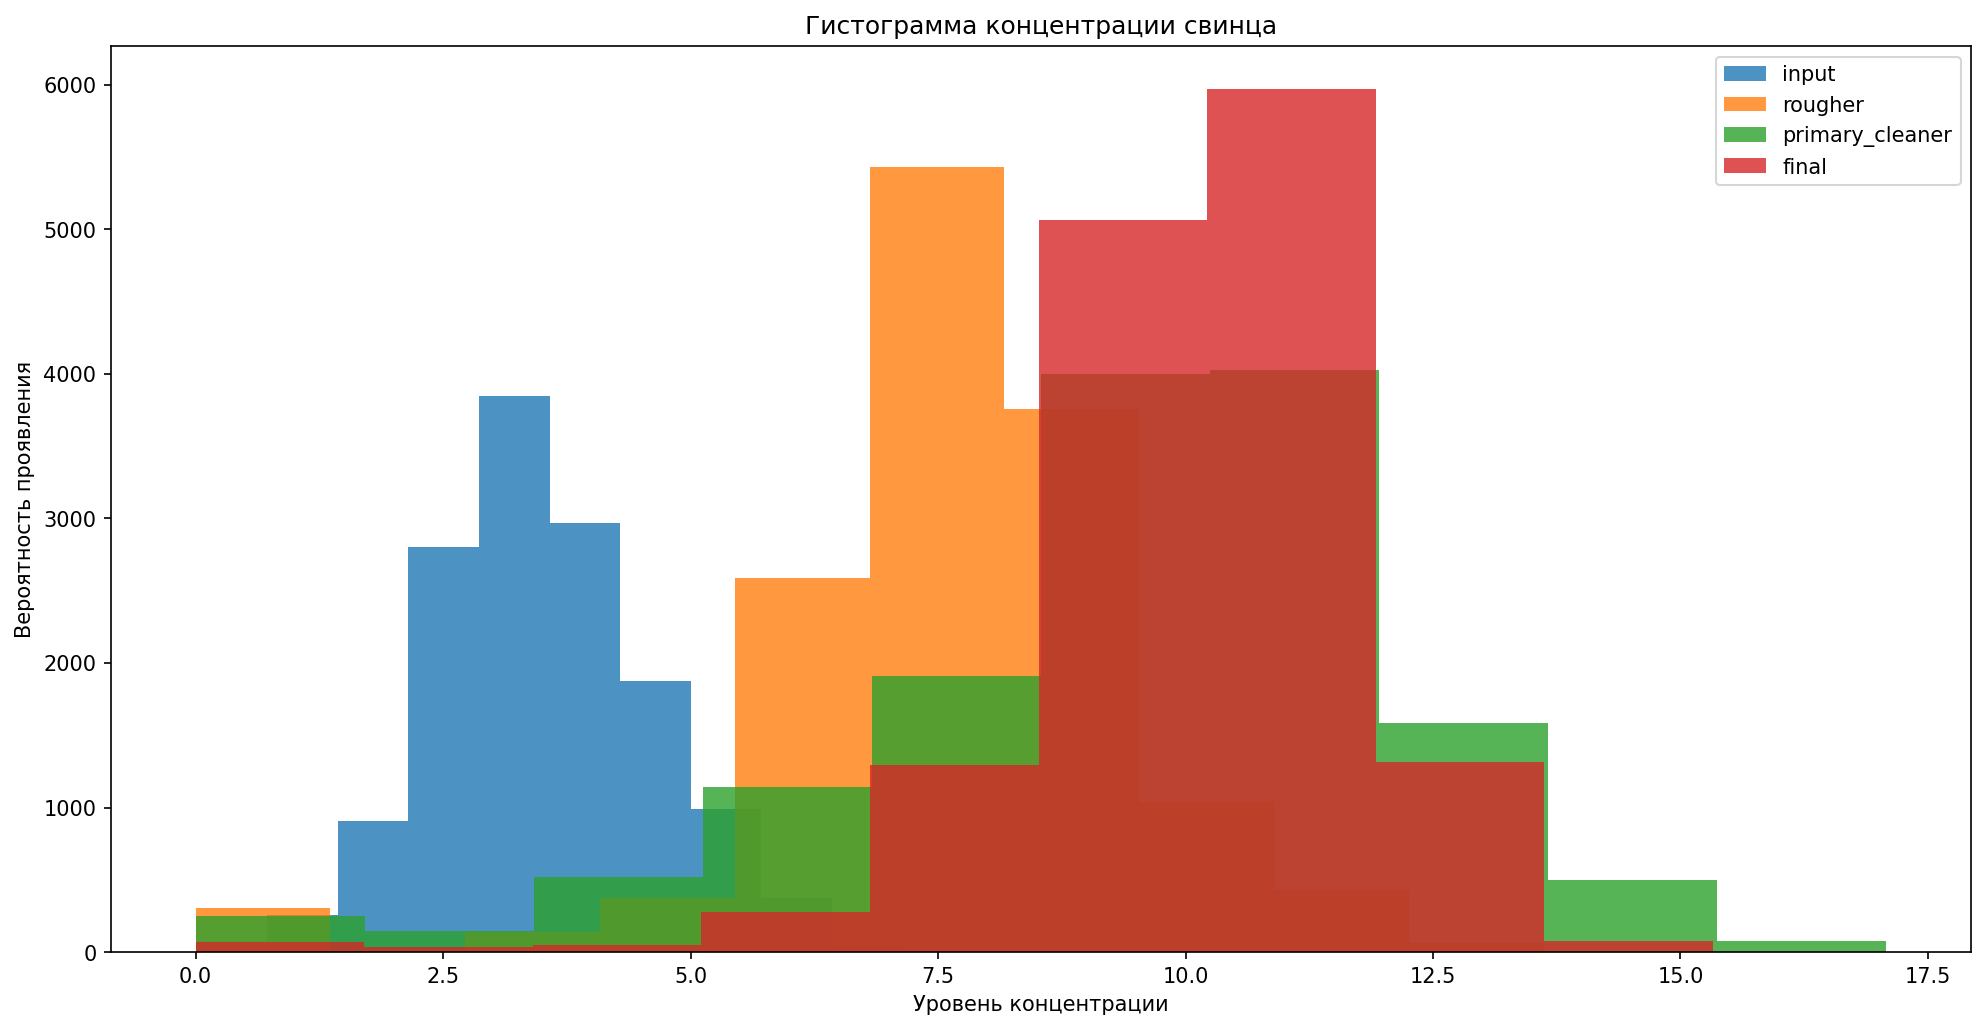

In [22]:
# строим гистограмму концентрации свинца на разных этапах очистки

plt.figure(figsize=(16, 8), dpi=150); 

data_train['rougher.input.feed_pb'].plot(kind='hist',label='input', alpha=.8)
data_train['rougher.output.concentrate_pb'].plot(kind='hist',label='rougher', alpha=.8)
data_train['primary_cleaner.output.concentrate_pb'].plot(kind='hist',label='primary_cleaner', alpha=.8)
data_train['final.output.concentrate_pb'].plot(kind='hist',label='final', alpha=.8)

plt.title('Гистограмма концентрации свинца')
plt.xlabel('Уровень концентрации')
plt.ylabel('Вероятность проявления')
plt.legend()
plt.show();

Из графиков видно, что:
  
- **золото**: концентрации увеличивается на каждом этапе очистки
- **серебро**: концентрация уменьшается на каждом этапе очистки
- **свинец**: концентрация повысилась к финальному этапу   
  
У всех трех металлов видны отдельные значения в районе нуля - видимо, это выбросы. Удалим их для дальнейшей работы. 

In [23]:
# удалим аномальные нулевые значения в нужных нам столбцах

data_train = data_train[
    (data_train['rougher.input.feed_au'] != 0)
    & (data_train['rougher.input.feed_ag'] != 0)
    & (data_train['rougher.input.feed_pb'] != 0) 
    & (data_train['rougher.input.feed_sol'] != 0)]

data_train = data_train[
    (data_train['rougher.output.concentrate_au'] != 0)
    & (data_train['rougher.output.concentrate_ag'] != 0)
    & (data_train['rougher.output.concentrate_pb'] != 0) 
    & (data_train['rougher.output.concentrate_sol'] != 0)]

data_train = data_train[
    (data_train['primary_cleaner.output.concentrate_au'] != 0)
    & (data_train['primary_cleaner.output.concentrate_ag'] != 0)
    & (data_train['primary_cleaner.output.concentrate_pb'] != 0) 
    & (data_train['rougher.output.concentrate_sol'] != 0)]

data_train = data_train[
    (data_train['final.output.concentrate_au'] != 0)
    & (data_train['final.output.concentrate_ag'] != 0)
    & (data_train['final.output.concentrate_pb'] != 0)
    & (data_train['rougher.output.concentrate_sol'] != 0)]

### Распределения размеров гранул сырья на обучающей и тестовой выборках

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.  
  
Нас интерисуют стоблцы:
- `rougher.input.feed_size` 
- `primary_cleaner.input.feed_size`
  
Построим для них гистограммы сравнения на обучающей и тестовой выборках.

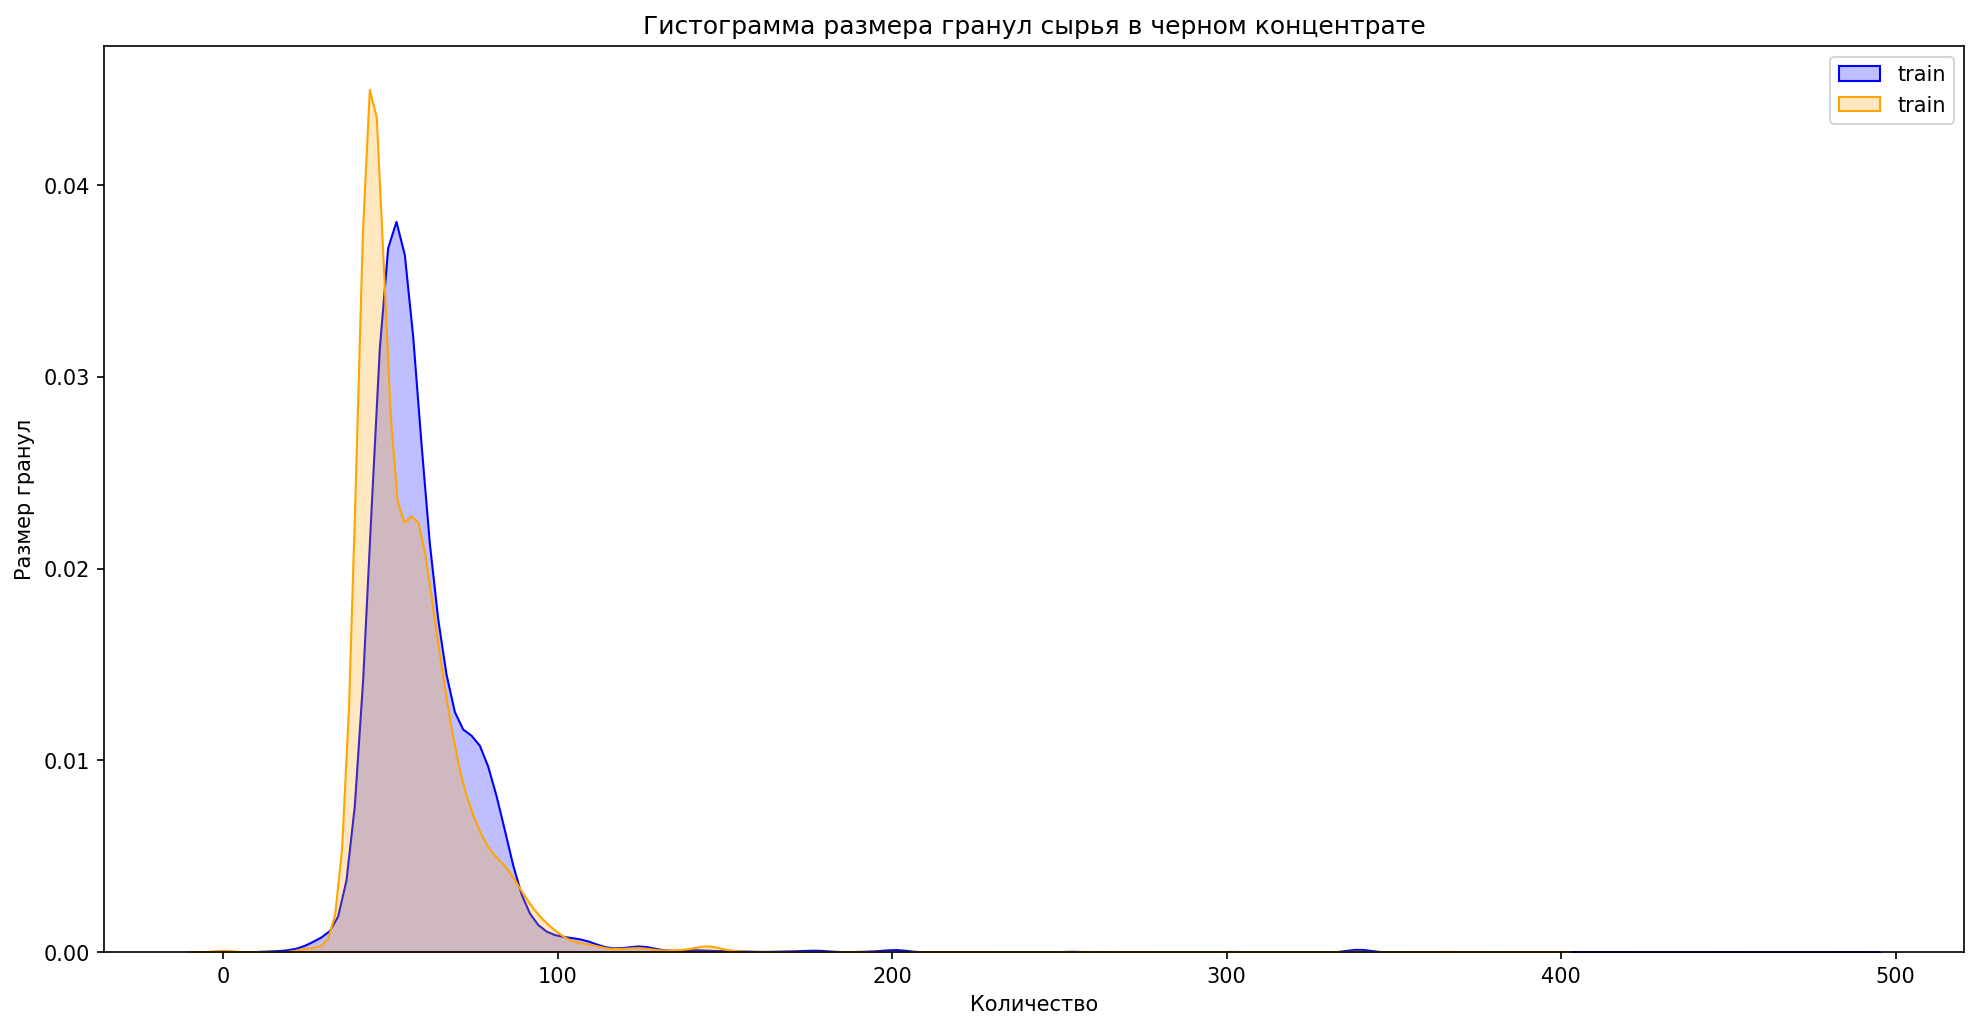

In [24]:
# строим гистограмму для размера гранул на входе в черном концентрате

plt.figure(figsize=(16, 8), dpi=150); 

sns.kdeplot(data=data_train['rougher.input.feed_size'], fill=True , color = "Blue", label='train')
sns.kdeplot(data=data_test['rougher.input.feed_size'], fill=True , color = "Orange", label='train')

plt.title('Гистограмма размера гранул сырья в черном концентрате')
plt.xlabel('Количество')
plt.ylabel('Размер гранул')
plt.legend()
plt.show();

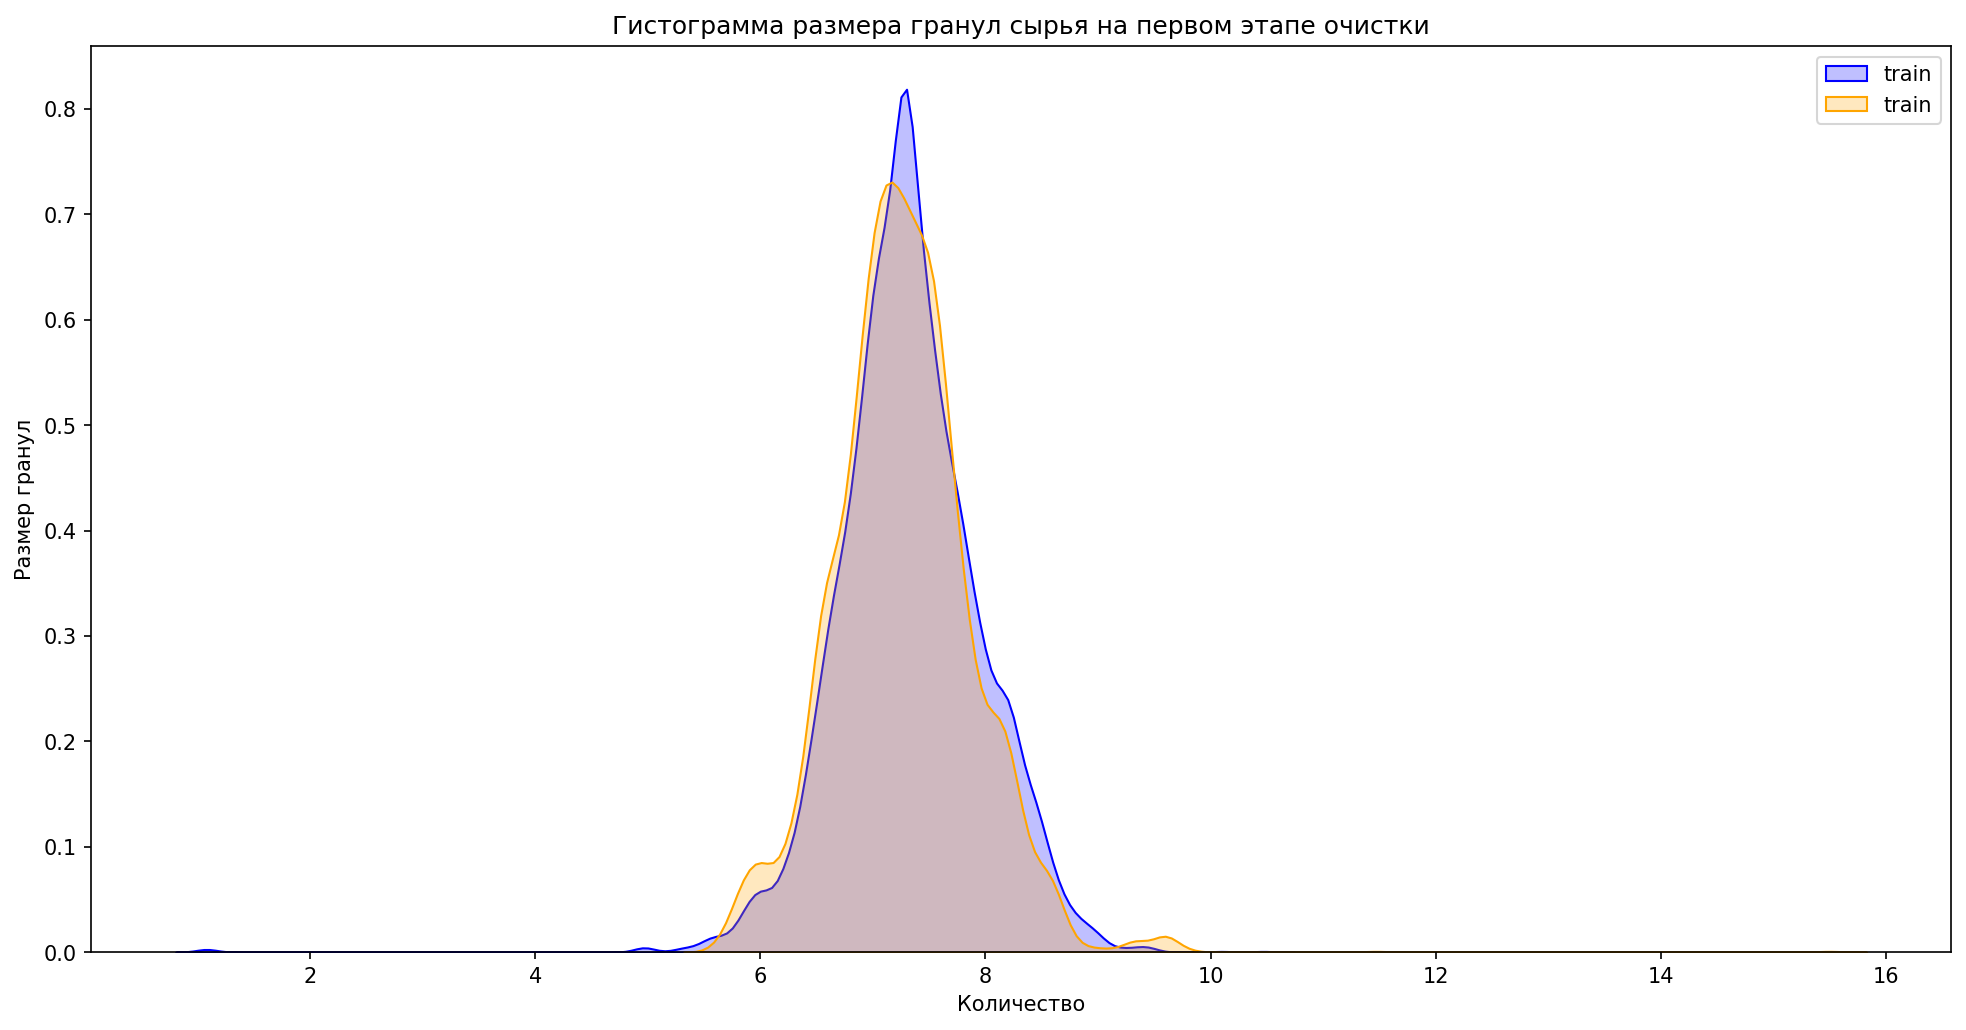

In [25]:
# строим гистограмму для размера гранул на первом этапе очистки

plt.figure(figsize=(16, 8), dpi=150); 

sns.kdeplot(data=data_train['primary_cleaner.input.feed_size'], fill=True , color = "Blue", label='train')
sns.kdeplot(data=data_test['primary_cleaner.input.feed_size'], fill=True , color = "Orange", label='train')

plt.title('Гистограмма размера гранул сырья на первом этапе очистки')
plt.xlabel('Количество')
plt.ylabel('Размер гранул')
plt.legend()
plt.show();

Распределения похожи, но первичном этапе очистки мы видим нормальное распределние, это означает, что с данными все в порядке. Можно обучать и проверять на них модели.

###  Суммарная концентрация всех веществ на разных стадиях

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.   
  
Нас интерисуют следующие столбцы данных:  
  
- `final.output.concentrate_ag`
- `final.output.concentrate_pb`
- `final.output.concentrate_sol`
- `final.output.concentrate_au`
- `primary_cleaner.output.concentrate_ag`
- `primary_cleaner.output.concentrate_pb`
- `primary_cleaner.output.concentrate_sol`
- `primary_cleaner.output.concentrate_au`
- `rougher.output.concentrate_ag`
- `rougher.output.concentrate_pb`
- `rougher.output.concentrate_sol`
- `rougher.output.concentrate_au`


In [26]:
# пропишем суммарную концентрацию для каждого вещества на разных стадиях: в сырье, в черновом и финальном концентратах


rougher_total_concentrate = (data_train['rougher.output.concentrate_ag'] + 
                             data_train['rougher.output.concentrate_pb'] +
                             data_train['rougher.output.concentrate_sol'] + 
                             data_train['rougher.output.concentrate_au'])

primary_total_concentrate = (data_train['primary_cleaner.output.concentrate_ag'] + 
                             data_train['primary_cleaner.output.concentrate_pb'] + 
                             data_train['primary_cleaner.output.concentrate_sol'] + 
                             data_train['primary_cleaner.output.concentrate_au'])


final_total_concentrate = (data_train['final.output.concentrate_ag'] + 
                           data_train['final.output.concentrate_pb'] + 
                           data_train['final.output.concentrate_sol'] + 
                           data_train['final.output.concentrate_au'])


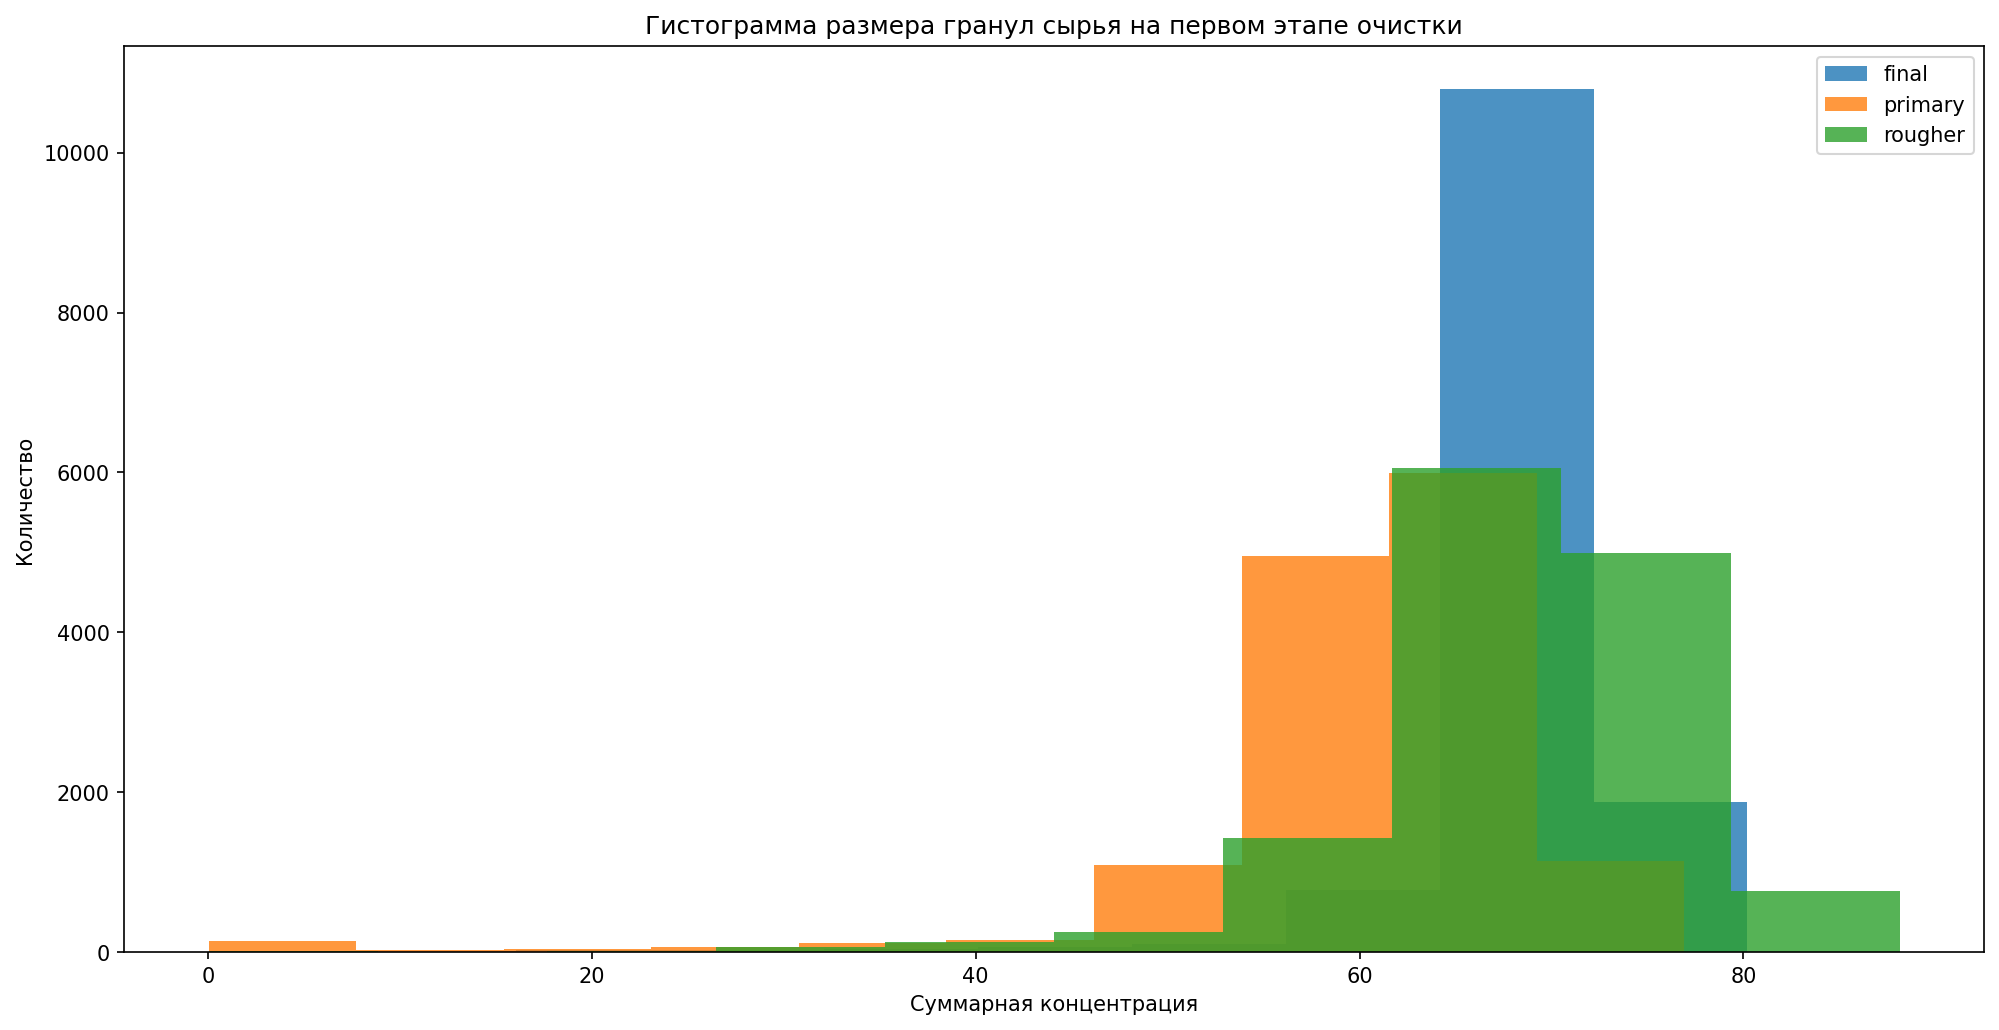

In [27]:
# строим гистограмму для суммарной концентрации веществ

plt.figure(figsize=(16, 8), dpi=150); 

final_total_concentrate.plot(kind='hist',label='final', alpha=.8)
primary_total_concentrate.plot(kind='hist',label='primary', alpha=.8)
rougher_total_concentrate.plot(kind='hist',label='rougher', alpha=.8)

plt.title('Гистограмма размера гранул сырья на первом этапе очистки')
plt.xlabel('Суммарная концентрация')
plt.ylabel('Количество')
plt.legend()
plt.show();

Из гистограмм видно, что суммарная концентрация веществ на каждой стадии повышается. Это хорошо.  
На графике вновь видим аномальные значения в районе нуля. Нужно их обработать.  
  
Но сначала вернемся к тем, какие мы имеем столбцы в обучающей выборке. После того, как мы проанализировали данные, мы можем оставить в обучающей выборке только нужные нам столбцы для построения моделей. Это такие столбцы, как в тестовой выборке.

In [28]:
# удалим аномальные нулевые значения в нужных нам столбцах

data_train = data_train[
    (data_train['rougher.output.concentrate_au'] != 0)
    & (data_train['rougher.output.concentrate_ag'] != 0)
    & (data_train['rougher.output.concentrate_pb'] != 0)
    & (data_train['rougher.output.concentrate_sol'] != 0)]

data_train = data_train[
    (data_train['primary_cleaner.output.concentrate_au'] != 0)
    & (data_train['primary_cleaner.output.concentrate_ag'] != 0)
    & (data_train['primary_cleaner.output.concentrate_pb'] != 0) 
    & (data_train['primary_cleaner.output.concentrate_sol'] != 0)]

data_train = data_train[
    (data_train['final.output.concentrate_au'] != 0)
    & (data_train['final.output.concentrate_ag'] != 0)
    & (data_train['final.output.concentrate_pb'] != 0) 
    & (data_train['final.output.concentrate_sol'] != 0)]

In [29]:
# оставим в обучающей выборке такие столбцы, как и в тестовой

not_in_test_2 = data_train.drop(columns=list(data_test.columns))
data_train = data_train.drop(columns=list(not_in_test_2.columns))

data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13716 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        13716 non-null  object 
 1   final.output.recovery                       13716 non-null  float64
 2   primary_cleaner.input.sulfate               13716 non-null  float64
 3   primary_cleaner.input.depressant            13716 non-null  float64
 4   primary_cleaner.input.feed_size             13716 non-null  float64
 5   primary_cleaner.input.xanthate              13716 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      13716 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    13716 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      13716 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    13716 non-null  float64
 10  primary_cl

Мы видим, что столбцы, которые мы анализировали ранее, исчезли из выборки, но осталось 8 столбцов, в которых тоже могут быть выбросы. Это:  
  
- `rougher.input.feed_ag`
- `rougher.input.feed_pb`
- `rougher.input.feed_rate`
- `rougher.input.feed_size`
- `rougher.input.feed_sol`
- `rougher.input.feed_au`
- `rougher.output.recovery`
- `final.output.recovery`
  
Удалим в них  анамалии в районе нуля.



In [30]:
# удалим аномальные нулевые значений в нужных нам столбцах

data_train = data_train[
    (data_train['rougher.input.feed_ag'] != 0)
    & (data_train['rougher.input.feed_pb'] != 0)
    & (data_train['rougher.input.feed_rate'] != 0)
    & (data_train['rougher.input.feed_size'] != 0)
    & (data_train['rougher.input.feed_sol'] != 0)
    & (data_train['rougher.input.feed_au'] != 0)
    & (data_train['rougher.output.recovery'] != 0)
    & (data_train['rougher.output.recovery'] != 0)]

С данными все в порядке, переходим к выводу по этому этапу и двигаемся дальше к моделям машинного обучения.

### Вывод

  
На этом этапе мы провели анализ данных и выяснили, что:   
  
- концентрация золота увеличивается на каждом этапе очистки,  серебра - уменьшается, а свинца - повысилась к финальному этапу
- распределения размеров гранул сырья в черновом и на первом этапе очистки похожи, мы видим нормальное распределние, это означает, что с данными все в порядке
- суммарная концентрация веществ на каждой стадии повышается
  
На этом этапе мы убрали лишние столбцы из обучающей выборки и оставили только совпадающие с тестовой. Это будет удобно для работы далее с моделями машинного обучения.

## Обучение моделей

### Функция для вычисления итоговой sMAPE

Нам нужно написать функции для расчета симметричной средней абсолютной процентной ошибке (SMAPE или sMAPE). Она послужит нам ддя проверки меры точности моделей. 

In [31]:
# функция для расчета SMAPE

def smape(target, predict):
    smape = (1/len(target))*np.sum((np.abs(target - predict))/( (np.abs(target)+np.abs(predict))/2))*100
    return smape

In [32]:
# зададим счетчик

smape_scorer = make_scorer(smape, greater_is_better = False)

In [33]:
# функция для расчета итогового SMAPE 

def overall_smape(rougher, final):
    overall = 0.25*rougher+0.75*final
    return overall

### Подготовка признаков

Сначала обозначим целевые признаки и фичи на обучающей и тестовой выборках для чернового и финального концентратов.

In [34]:
# признаки на обучающей выборке

features_train = data_train.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
target_train_rougher = data_train['rougher.output.recovery']
target_train_final = data_train['final.output.recovery']

In [35]:
# признаки на тестовой выборке 

features_test = data_test.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
target_test_rougher = data_test['rougher.output.recovery']
target_test_final = data_test['final.output.recovery']

In [36]:
# стандартизируем численные признаки в обучающей выборке

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

### Модель линейная регрессия

In [37]:
%%time

# обучим модель линейной регрессии для этапа rougher
# оценим качетсво модели кросс-валидацией
# посчитаем smape

model_lin_reg_r = LinearRegression()

scores_lin_reg_r = cross_val_score(model_lin_reg_r,
                                    features_train, 
                                    target_train_rougher, 
                                    scoring = smape_scorer,
                                    cv = 5)

smape_lin_reg_rougher = np.mean(abs(scores_lin_reg_r))

print(scores_lin_reg_r)
print()
print('Средняя оценка качества smape', round(smape_lin_reg_rougher, 2))

[-9.67000578 -7.21172257 -5.57226237 -4.872968   -9.02316877]

Средняя оценка качества smape 7.27
CPU times: user 378 ms, sys: 656 ms, total: 1.03 s
Wall time: 944 ms


In [38]:
%%time

# обучим модель линейной регрессии для этапа final
# оценим качетсво модели кросс-валидацией
# посчитаем smape

model_lin_reg_f = LinearRegression()

scores_lin_reg_f = cross_val_score(model_lin_reg_f,
                                   features_train, 
                                   target_train_final,
                                   scoring = smape_scorer,
                                   cv = 5)

smape_lin_reg_final = np.mean(abs(scores_lin_reg_f))

print(scores_lin_reg_f)
print()
print('Средняя оценка качества smape', round(smape_lin_reg_final, 2))

[-13.33259636  -9.73229812  -9.24338651  -9.08241267 -13.31342734]

Средняя оценка качества smape 10.94
CPU times: user 467 ms, sys: 810 ms, total: 1.28 s
Wall time: 1.3 s


In [39]:
# вычислим итоговую оценку smape

smape_overall_lin_reg = overall_smape(smape_lin_reg_rougher, smape_lin_reg_final)

print('Средняя итоговая оценка качества модели smape ', round(smape_overall_lin_reg, 2))

Средняя итоговая оценка качества модели smape  10.02


### Модель решающее дерево в регрессии

In [40]:
state = RandomState(12345)

In [41]:
%%time

# обучим модель решающее дерево для этапа rougher
# оценим качетсво модели кросс-валидацией
# посчитаем smape

best_model_tree_rougher = None
best_result_tree_rougher = 100

scores_tree_rougher = []

for depth in range(1, 30, 1):
    model_tree_rougher = DecisionTreeRegressor(max_depth=depth, random_state=state)
    
    scores_tree_rougher = cross_val_score(model_tree_rougher,
                                          features_train,
                                          target_train_rougher,
                                          scoring=smape_scorer,
                                          cv=5)
    

    smape_tree_rougher = np.mean(abs(scores_tree_rougher))
    
    if smape_tree_rougher < best_result_tree_rougher:
        best_model_tree_rougher = model_tree_rougher
        best_result_tree_rougher = smape_tree_rougher
    
    
print(best_model_tree_rougher)
print()
print('Средняя оценка качества smape', round(best_result_tree_rougher, 2))

DecisionTreeRegressor(max_depth=4,
                      random_state=RandomState(MT19937) at 0x7EFFBC0DE640)

Средняя оценка качества smape 7.32
CPU times: user 1min 20s, sys: 94.1 ms, total: 1min 21s
Wall time: 1min 21s


In [42]:
%%time

# обучим модель решающее дерево для этапа rougher
# оценим качетсво модели кросс-валидацией
# посчитаем smape

best_model_tree_final = None
best_result_tree_final = 100

scores_tree_final = []

for depth in range(1, 30, 1):
    model_tree_final = DecisionTreeRegressor(max_depth=depth, random_state=state)
    
    scores_tree_final = cross_val_score(model_tree_final,
                                        features_train,
                                        target_train_final,
                                        scoring=smape_scorer,
                                        cv=5)
    
    smape_tree_final = np.mean(abs(scores_tree_final))
    
    if smape_tree_final < best_result_tree_final:
        best_model_tree_final = model_tree_final
        best_result_tree_final = smape_tree_final
    

print(best_model_tree_final)
print()
print('Средняя оценка качества smape', round(smape_tree_final, 2))

DecisionTreeRegressor(max_depth=3,
                      random_state=RandomState(MT19937) at 0x7EFFBC0DE640)

Средняя оценка качества smape 14.89
CPU times: user 1min 26s, sys: 140 ms, total: 1min 27s
Wall time: 1min 27s


In [43]:
# вычислим итоговую оценку smape

smape_overall_tree = overall_smape(smape_tree_rougher, smape_tree_final)

print('Средняя итоговая оценка качества модели smape ', round(smape_overall_tree, 2))

Средняя итоговая оценка качества модели smape  13.84


### Модель случайный лес в регрессии

In [44]:
%%time

# обучим модель случайный лес для этапа rougher
# оценим качетсво модели кросс-валидацией
# посчитаем smape

best_model_forest_r = None
best_result_forest_r = 10000
best_est_forest_r = 0
best_depth_forest_r = 0

for est in range(10, 100, 30):
    for depth in range(2,30,2):
        model_forest_rougher = RandomForestRegressor(n_estimators=est, 
                                                     max_depth=depth, 
                                                     random_state=state)
        
        scores_forest_rougher = cross_val_score(model_forest_rougher,
                                                features_train,
                                                target_train_rougher,
                                                scoring=smape_scorer,
                                                cv=5)
        
        smape_forest_rougher = np.mean(abs(scores_forest_rougher))
        
        if smape_forest_rougher < best_result_forest_r:
            best_model_forest_r = model_forest_rougher
            best_result_forest_r = smape_forest_rougher
            best_est_forest_r = est
            best_depth_forest_r = depth
        
print(best_model_forest_r)
print(best_est_forest_r, best_depth_forest_r)
print()
print('Средняя оценка качества smape_forest_rougher', round(smape_forest_rougher, 2))

RandomForestRegressor(max_depth=4, n_estimators=10,
                      random_state=RandomState(MT19937) at 0x7EFFBC0DE640)
10 4

Средняя оценка качества smape_forest_rougher 7.16
CPU times: user 48min 49s, sys: 2.59 s, total: 48min 51s
Wall time: 48min 56s


In [45]:
%%time

# обучим модель слуайный лес для этапа final
# оценим качетсво модели кросс-валидацией
# посчитаем smape

best_model_forest_f = None
best_result_forest_f = 10000
best_est_forest_f = 0
best_depth_forest_f = 0

for est in range(10, 100, 30):
    for depth in range(2,30,2):
        model_forest_final = RandomForestRegressor(n_estimators=est, 
                                                   max_depth=depth, 
                                                   random_state=state)
        
        scores_forest_final = cross_val_score(model_forest_final,
                                                features_train,
                                                target_train_final,
                                                scoring=smape_scorer,
                                                cv=5)
        
        smape_forest_final = np.mean(abs(scores_forest_final))
        
        if smape_forest_final < best_result_forest_f:
            best_model_forest_f = model_forest_final
            best_result_forest_f = smape_forest_final
            best_est_forest_f = est
            best_depth_forest_f = depth
        
print(best_model_forest_f)
print(best_est_forest_f, best_depth_forest_f)
print()
print('Средняя оценка качества smape', round(smape_forest_final, 2))

RandomForestRegressor(max_depth=4, n_estimators=40,
                      random_state=RandomState(MT19937) at 0x7EFFBC0DE640)
40 4

Средняя оценка качества smape 9.83
CPU times: user 52min 33s, sys: 2.33 s, total: 52min 36s
Wall time: 52min 41s


In [46]:
# вычислим итоговую оценку smape

smape_overall_forest = overall_smape(smape_forest_rougher, smape_forest_final)

print('Средняя итоговая оценка качества модели smape ', round(smape_overall_forest, 2))

Средняя итоговая оценка качества модели smape  9.17


После обучения моделей, кросс-валидации и расчетов SMAPE мы имеем следующий результат:
      
- `LinearRegression`: rougher - 7.27; final - 10.94; overall - 10.02
- `DesisionTreeRegressor`: rougher - 7.32; final - 14.89; overall - 13.84
- `RandomForestRegressor`: rougher - 7.16; final - 9.83; overall - 9.17

Делаем вывод, что лучшая модель для черновой и финальной этапов обработки `RandomForestRegressor` с параметрами: estimators = 40; depth = 4.  
Проверим ее на тестовой выборке.

### Проверка выбранной модели на тестовой выборке

In [47]:
%%time

# проверим модель слуайный лес для этапа rougher
# посчитаем smape

model_test_rougher = RandomForestRegressor(n_estimators=40, 
                                           max_depth=4, 
                                           random_state=state)

model_test_rougher.fit(features_train, target_train_rougher)
predicted_rougher = model_test_rougher.predict(features_test)

smape_test_rougher = smape(target_test_rougher, predicted_rougher)

print('Средняя оценка качества smape_test_rougher', round(smape_test_rougher, 2))

Средняя оценка качества smape_test_rougher 8.13
CPU times: user 7.37 s, sys: 0 ns, total: 7.37 s
Wall time: 7.38 s


In [48]:
%%time

# проверим модель слуайный лес для этапа final
# посчитаем smape

model_test_final = RandomForestRegressor(n_estimators=40, 
                                         max_depth=4, 
                                         random_state=state)

model_test_final.fit(features_train, target_train_final)
predicted_final = model_test_final.predict(features_test)

smape_test_final = smape(target_test_final, predicted_final)

print('Средняя оценка качества smape_test_final', round(smape_test_final, 2))

Средняя оценка качества smape_test_final 9.36
CPU times: user 7.45 s, sys: 27.9 ms, total: 7.48 s
Wall time: 7.49 s


In [49]:
# вычислим итоговую оценку smape

overall_smape_test = overall_smape(smape_test_rougher, smape_test_final)

print('Средняя итоговая оценка качества модели overall_smape_test', round(overall_smape_test, 2))

Средняя итоговая оценка качества модели overall_smape_test 9.06


На тестовой выборке мы получили:  
  
- smape для этапа rougher: 8.13
- smape для этапа final: 9.36
- итоговая оценка smape: 9.06
  
Осталось проверить модель на адекватность на константной модели и можно делать выводы.

### Проверка модели на адекватность

In [50]:
# провеорим адекватность на константной модели для этапа rougher
# вычислим smape

dummy_rougher = DummyRegressor(strategy="mean")
dummy_rougher.fit(features_train, target_train_rougher)
dummy_predicted_rougher = dummy_rougher.predict(features_test)

smape_dummy_rougher = smape(target_test_rougher, dummy_predicted_rougher)

print('Средняя оценка качества smape_dummy_rougher', round(smape_dummy_rougher, 2))

Средняя оценка качества smape_dummy_rougher 9.06


In [51]:
# провеорим адекватность на константной модели для этапа rougher
# вычислим smape

dummy_final = DummyRegressor(strategy="mean")
dummy_final.fit(features_train, target_train_final)
dummy_predicted_final = dummy_final.predict(features_test)

smape_dummy_final = smape(target_test_final, dummy_predicted_final)

print('Средняя оценка качества smape_dummy_final', round(smape_dummy_final, 2))

Средняя оценка качества smape_dummy_final 10.08


In [52]:
# вычислим итоговую оценку smape длдля константной модели

smape_dummy_overall = overall_smape(smape_dummy_rougher, smape_dummy_final)

print('Средняя итоговая оценка качества модели final_smape_for_const', round(smape_dummy_overall, 2))

Средняя итоговая оценка качества модели final_smape_for_const 9.83


Итак, константная модель показала следующий результат:   
   
- smape для этапа rougher: 9.06
- smape для этапа final: 10.08
- итоговая оценка smape: 9.83  
  
Наша модель на тестовой выборке дала результат чуть лучше и значит она работает. 

### Вывод

Мы обучили модели, расчиатали SMAPE и получили следующий результат:  
  
- LinearRegression: rougher - 7.27; final - 10.94; overall - 10.02
- DesisionTreeRegressor: rougher - 7.32; final - 14.89; overall - 13.84
- RandomForestRegressor: rougher - 7.16; final - 9.83; overall - 9.17

Таким образом, на обучающей выборке лучшей показала себя модель для черновой и финальной этапов обработки RandomForestRegressor с параметрами: estimators - 40; depth - 4.  
  
При проверке модели на тестовой выборке мы получили:

- smape для этапа rougher: 8.13
- smape для этапа final: 9.36
- итоговая оценка smape: 9.06

На константной модели мы получили:   
   
- smape для этапа rougher: 9.06
- smape для этапа final: 10.08
- итоговая оценка smape: 9.83
  
Значения похожи на те, что модель показала на тестовой выборке. Модель работает.

## Итоговый вывод

Нам нужно было подготовить прототип модели машинного обучения для компании «Цифра». По задаче от заказчика, она должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении имелись данные с параметрами добычи и очистки. Модель должна помочь оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В ходе работы мы: 

1. **Подготовили данные**
   
    На данном этапе мы изучили и подготовили данные для дальнейшей работы:
     
    - проверили дубликаты, пропуски  
    - посчитали значение MAE и выснили, что его значение почти 0, поэтому можно сделать вывод, что вычисление эффективности обогащения в данных датасета верные 
    - проверили, каких данных не хватает в тестовой выборке и добавили два столбца `rougher.output.recovery` и `final.output.recovery` для дальнейшей работы с моделями машинного обучения 
    - заполнили пропуски в данных  
      
   В итоге у нас получилось три подготовленных датасета с данными без явных дубликатов и без пропусков:  
  
    - `data_train` - размером 88 столбцов и 14149 строк
    - `data_test` - размером 55 столбцов и 5290 строк
    - `data_full`- размером 87 столбцов и 19439 строк  
      
        
        
  
2. **Провели анализ данных**
     
   На этом этапе получили:
     
    - концентрация золота увеличивается на каждом этапе очистки,  серебра - уменьшается, а свинца - повысилась к финальному этапу
    - распределения размеров гранул сырья в черновом и на первом этапе очистки похожи, мы видим нормальное распределние, это означает, что с данными все в порядке
    - суммарная концентрация веществ на каждой стадии повышается
  
   На этом этапе мы убрали лишние столбцы из обучающей выборки и оставили только совпадающие с тестовой. Это будет удобно для работы далее с моделями машинного обучения.
   
  
3. **Построили модель прогнозирования:**  
  
   Мы протестировали три модели:   
     
     - LinearRegression: rougher - 7.27; final - 10.94; overall - 10.02
     - DesisionTreeRegressor: rougher - 7.32; final - 14.89; overall - 13.84
     - RandomForestRegressor: rougher - 7.16; final - 9.83; overall - 9.17  
  
   Таким образом мы выяснили, что лучше всего на наших данных прогнозирует модель  `RandomForestRegressor` с параметрами: estimators - 40; depth - 4.  
     
   На тестовой выборке модель показала: 
     
   - smape для этапа rougher: 8.14
   - smape для этапа final: 10.03
   - итоговая оценка smape: 9.56
     
   На константной модели результат: 
             
   - smape для этапа rougher: 9.06
   - smape для этапа final: 10.08
   - итоговая оценка smape: 9.83 
   
**Вывод:** для прогнозирования коэффициента восстановления золота из золотосодержащей руды лучше всего использовать обученную на предоставленных данных модель `RandomForestRegressor` с параметрами: estimators - 40; depth - 4.